In [ ]:
# https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import math
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


STOCKS_DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/stocks/"

df = pd.read_csv(STOCKS_DIRECTORY + 'AMZN' + ".csv")

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

train = new_data[:math.floor(len(new_data)*0.3)]
valid = new_data[math.floor(len(new_data)*0.3):]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
y_train=y_train.astype('int')

x_train['Date'] = pd.to_datetime(x_train['Date'])
x_train['Date']=x_train['Date'].map(dt.datetime.toordinal)

x_valid = valid.drop('Close', axis=1)

x_valid['Date'] = pd.to_datetime(x_valid['Date'])
x_valid['Date']=x_valid['Date'].map(dt.datetime.toordinal)

y_valid = valid['Close']

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Mean Squared Error:  724.9398574948021


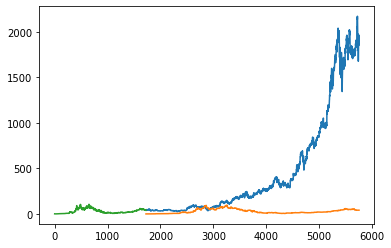

In [ ]:
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'chebyshev']}
clf_knn = KNeighborsClassifier()
knn = GridSearchCV(clf_knn, parameters, cv=5)

knn.fit(x_train, y_train)

knn_best_param = knn.best_params_
print(knn_best_param)

pred = knn.predict(x_valid)

print("Mean Squared Error: ", np.sqrt(mean_squared_error(y_valid, pred)))

valid['Predictions'] = pred
plt.rcParams.update({'font.size': 10})
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

{'criterion': 'gini', 'max_depth': 40}
Mean Squared Error:  724.7890121630296


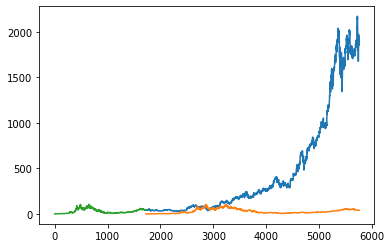

In [ ]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf_dt = DecisionTreeClassifier()
dt = GridSearchCV(clf_dt, tree_para, cv=5)

dt.fit(x_train, y_train)

dt_best_param = dt.best_params_
print(dt_best_param)

pred2 = dt.predict(x_valid)
print("Mean Squared Error: ", np.sqrt(mean_squared_error(y_valid, pred2)))

valid['Predictions'] = pred2
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'var_smoothing': 0.001873817422860383}
Mean Squared Error:  734.4085275326523


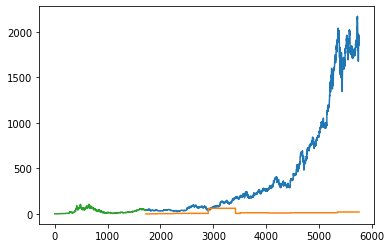

In [ ]:
param = {'var_smoothing': np.logspace(0,-9, num=100)}
clf_nb = GaussianNB()
nb = GridSearchCV(clf_nb, param, verbose=1, cv=10, n_jobs=-1)

nb.fit(x_train, y_train)

nb_best_param = nb.best_params_
print(nb_best_param)

pred3 = nb.predict(x_valid)

print("Mean Squared Error: ", np.sqrt(mean_squared_error(y_valid, pred3)))

valid['Predictions'] = pred3
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
import datetime as dt

# For NN we are splitting differently

df = pd.read_csv(STOCKS_DIRECTORY + 'AMZN' + ".csv", parse_dates = ['Date'], index_col=0)
df = df.dropna()


In [ ]:
col = 'Adj Close'

out = int(math.ceil(0.009*len(df)))

df['label'] = df[col].shift(-out)

X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X) 
X = X[:-out:]
X_lately = X[-out:] 

df.dropna(inplace=True)

y = np.array(df['label'])


In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(40,input_shape=(6,) , activation = 'relu'))
model.add(Flatten())
model.add(Dense(4, activation = 'linear'))
model.add(Dense(1, activation ='linear')) 

model.compile(optimizer='Adam', loss= 'mean_squared_error')

model.fit(X_train, y_train, batch_size = 10, epochs=100)

In [ ]:
pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns = ['pred']) 

close_P = pd.DataFrame(y_test,columns = ['close'])

range_Date = pd.date_range("2020-01-31","2020-12-19")
range_Date = pd.DataFrame(data=range_Date, columns = ['date'])

prediction = range_Date.join(pred)
close_2 = range_Date.join(close_P)

close_2.index = close_2['date'] 
close_2.drop(['date'], axis=1, inplace =True)

prediction.index = prediction['date']
prediction.drop(['date'], axis=1, inplace =True)


joined_Data = pd.concat([close_2, prediction], axis=1, sort=False)


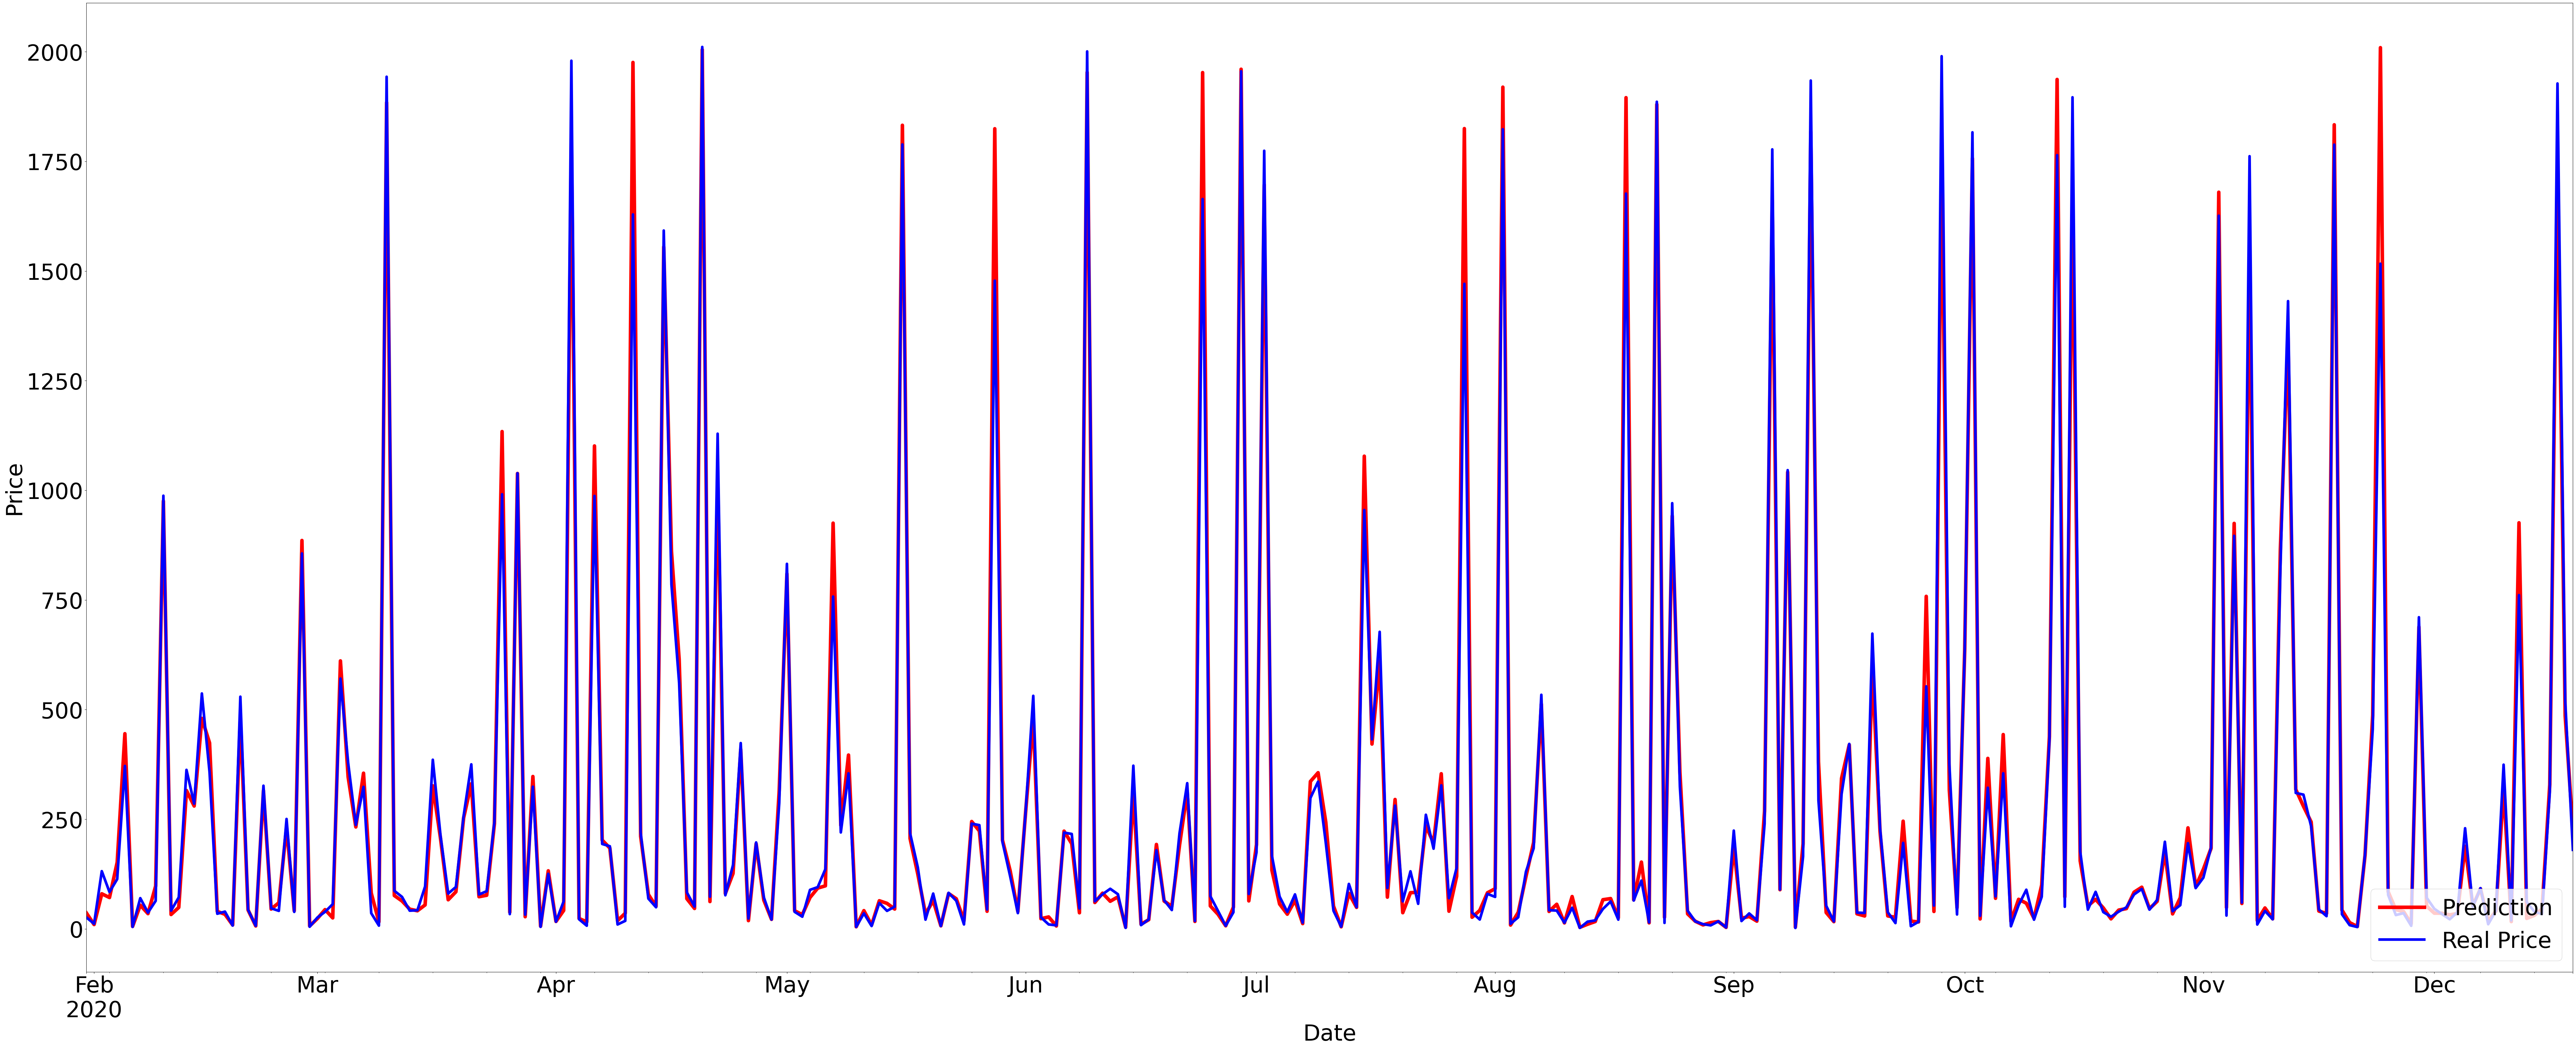

In [ ]:
from matplotlib.pyplot import figure

plt.figure(num=None, figsize=(100, 40), dpi=100, facecolor='w')
joined_Data['pred'].plot(color = 'red', label='Prediction', linewidth=8)
joined_Data['close'].plot(color = 'blue', label='Real Price', linewidth=6)
plt.legend(loc=4, prop={'size': 50})
plt.xlabel('Date')
plt.ylabel('Price')
plt.rcParams.update({'font.size': 50})
plt.show()
